In this notebook, we will explore Gaussian Process Machine Learning model for the methanol dataset. The hold-out set containing three electrophiles of 1H-indol-5-yl N,N-dimethylsulfamate, Ethyl 4-chloro-3-fluorobenzoate, and Clofibrate will be used as the external electrophile testing set.

# Machine Learning for Nickel Catalyzed Borylation in MeOH

In [1]:
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math as math
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso

### Load Preprocessed Ethanol Dataset

In [2]:
dataset = pd.read_csv("./data/data_MeOH_Final.csv")
dataset.head()

,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Ligand,Ligand_inchi,Product_inchi,Solvent_inchi,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,50.731606,50.731606,351.19888,1.840787,-0.055960,A-paPhos,InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",88.86
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,80.673770,61.935337,479.46484,1.803143,-0.058457,CX-FBu,InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",54.07
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,107.755370,56.694310,386.44120,1.805810,-0.058387,CX-PCy,InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-1...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",74.99
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,117.597336,54.091050,618.03375,1.817123,-0.054418,Cy-BippyPhos,InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",82.92
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,111.484024,57.033180,402.37967,1.816461,-0.061351,Cy-JohnPhos,InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",80.25


### Prepare Hold-out Electrophiles Testing Set¶

In [3]:
dataset.Electrophile.unique().tolist()

['1H-indol-5-yl\xa0N,N-dimethylsulfamate',
 "2-bromo-1,1'-biphenyl",
 '2-Chloro-5-fluorotoluene',
 '2-Chloro-m-xylene',
 '(2-Methyl-1,3-benzothiazol-5-yl)\xa0N,N-dimethylsulfamate',
 '3-Bromothiophene',
 '3-Chloro-2-methylaniline',
 '4-Bromoanisole',
 '4-Bromobenzotrifluoride',
 '4-Chloro-N,N-dimethylbenzamide',
 '5-chloroindole',
 'BMS-929356',
 'Ethyl\xa04-chloro-3-fluorobenzoate',
 'methyl\xa04-bromobenzoate',
 'quinolin-6-yl dimethylsulfamate',
 '3-Bromoquinoline',
 '3-bromo-2-methylpyridine',
 'Clofibrate',
 '4-Bromo-2-fluoroanisole',
 '4-Bromo-2-fluorobenzonitrile',
 '(4-Phenylphenyl) N,N-dimethylsulfamate',
 '4-Bromo-1,2-(methylenedioxy)benzene',
 '5-Bromobenzofuran',
 '4-chloro-1-fluoro-2-methoxybenzene',
 '4-chlorobenzotrifluoride',
 '3-chloroquinoline',
 '5-bromo-2,4-dimethoxypyrimidine',
 'methyl\xa04-chlorobenzoate',
 '5-Chloro-1,3-benzodioxole',
 '4-chloro-2-fluoro-1-methoxybenzene',
 '4-Chloro-2-fluoroanisole',
 '4-Chlorobiphenyl',
 '4-Bromobiphenyl',
 '4-Chloro-2-fluorob

In [4]:
#Retrieve the three electrophiles and store the features in a separate dataframe 
indices=[0,12,17]
mapped = map(dataset.Electrophile.unique().tolist().__getitem__, indices)
external_list=list(mapped)
ML_data_validation = dataset[dataset['Electrophile'].isin(external_list)]
ML_data_validation2 = ML_data_validation.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_validation2.shape)
ML_data_validation2.head()

(69, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,88.86
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,54.07
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,74.99
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,82.92
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,80.25


In [5]:
#Keep the rest of the dataset for model training purpose
exclude_list = ML_data_validation.index.values.tolist()
ML_data_traintest = dataset[~dataset.index.isin(exclude_list)]
ML_data_traintest2 = ML_data_traintest.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_traintest2.shape)
ML_data_traintest2.head()

(710, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
23,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,48.175
24,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,22.925
25,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,70.335
26,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,73.775
27,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,55.420


In [6]:
Y_train = ML_data_traintest2['Yield']
X_train = ML_data_traintest2.drop(columns=['Yield'])

We will use Pipeline process from Scikit Learn where we can assemble several steps that can be cross-validated together while applying normalization and grid search to find optimal settings for different parameters.

### Lasso

In [7]:
%%time
steps = [('scaler', StandardScaler()), ('model', Lasso())]
pipeline = Pipeline(steps)
parameters = {'model__alpha': np.logspace(-10, 1, 50)}

lasso_search = GridSearchCV(pipeline, 
                         parameters, 
                         cv = 5, 
                         scoring="neg_mean_squared_error", 
                         verbose=3)

lasso_search.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .............................model__alpha=1e-10; total time=   0.1s
[CV 2/5] END .............................model__alpha=1e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.56137649706, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.10850853715, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.89140619393, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

[CV 3/5] END .............................model__alpha=1e-10; total time=   0.1s
[CV 4/5] END .............................model__alpha=1e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.9132823322, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.56119368189, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............................model__alpha=1e-10; total time=   0.1s
[CV 1/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.10826485658, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.8911048245, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.1s
[CV 3/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.6192296933, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.91295128979, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.1s
[CV 5/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.56088713068, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.10785624434, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=2.811768697974225e-10; total time=   0.1s
[CV 2/5] END .............model__alpha=2.811768697974225e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.89059947863, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.61876234924, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=2.811768697974225e-10; total time=   0.2s
[CV 4/5] END .............model__alpha=2.811768697974225e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.91239618618, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.56037309581, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=2.811768697974225e-10; total time=   0.1s
[CV 1/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.10717106929, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.8897520981, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.2s
[CV 3/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.61797869134, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.91146537077, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.1s
[CV 5/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.55951114568, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.10602214634, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=7.906043210907701e-10; total time=   0.2s
[CV 2/5] END .............model__alpha=7.906043210907701e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.88833118258, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.61666462859, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=7.906043210907701e-10; total time=   0.1s
[CV 4/5] END .............model__alpha=7.906043210907701e-10; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.90990454833, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.55806579863, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=7.906043210907701e-10; total time=   0.1s
[CV 1/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.10409559334, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.88594854454, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.1s
[CV 3/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.61446116389, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.90728731043, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.2s
[CV 5/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.55564219327, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.10086508628, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=2.222996482526191e-09; total time=   0.2s
[CV 2/5] END .............model__alpha=2.222996482526191e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.88195325811, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.61076632178, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=2.222996482526191e-09; total time=   0.2s
[CV 4/5] END .............model__alpha=2.222996482526191e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.90289863918, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.55157821234, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=2.222996482526191e-09; total time=   0.1s
[CV 1/5] END .............model__alpha=3.727593720314938e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.09544806546, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.87525382935, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=3.727593720314938e-09; total time=   0.2s
[CV 3/5] END .............model__alpha=3.727593720314938e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.60457068853, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.89553957118, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=3.727593720314938e-09; total time=   0.2s
[CV 5/5] END .............model__alpha=3.727593720314938e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.54476359501, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.08636462427, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=6.250551925273976e-09; total time=   0.1s
[CV 2/5] END .............model__alpha=6.250551925273976e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.86402000459, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.59418164442, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=6.250551925273976e-09; total time=   0.1s
[CV 4/5] END .............model__alpha=6.250551925273976e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.88319964505, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.53333662024, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=6.250551925273976e-09; total time=   0.1s
[CV 1/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.07113320866, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.84518274892, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.2s
[CV 3/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.57676094798, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.86250765217, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.2s
[CV 5/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.51417549037, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.04559265892, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.1s
[CV 2/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.81359579969, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.54754933603, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.2s
[CV 4/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.82781064548, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.48204547157, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.1s
[CV 1/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82434.0027653992, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.76062970607, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.1s
[CV 3/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.4985663027, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.76962958247, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.2s
[CV 5/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.42816878633, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82433.9309511663, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.1s
[CV 2/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.6718142611, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.41642982523, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.1s
[CV 4/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.67206971878, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.33782655197, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.2s
[CV 1/5] END .............model__alpha=8.286427728546843e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82433.81053049036, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.5228851581, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=8.286427728546843e-08; total time=   0.1s
[CV 3/5] END .............model__alpha=8.286427728546843e-08; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.27870035582, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.5084782927, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=8.286427728546843e-08; total time=   0.1s
[CV 5/5] END .............model__alpha=8.286427728546843e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76679.186337622, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82433.60860455941, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=1.389495494373136e-07; total time=   0.1s
[CV 2/5] END .............model__alpha=1.389495494373136e-07; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80084.2731546999, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80604.04775014851, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=1.389495494373136e-07; total time=   0.1s
[CV 4/5] END .............model__alpha=1.389495494373136e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74958.23416326917, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76678.93231572563, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=1.389495494373136e-07; total time=   0.2s
[CV 1/5] END .............model__alpha=2.329951810515372e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82433.27000688763, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80083.8543949727, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=2.329951810515372e-07; total time=   0.1s
[CV 3/5] END .............model__alpha=2.329951810515372e-07; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80603.6604827111, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74957.77418411853, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=2.329951810515372e-07; total time=   0.1s
[CV 5/5] END .............model__alpha=2.329951810515372e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76678.50636268545, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82432.70223060653, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=3.906939937054621e-07; total time=   0.2s
[CV 2/5] END .............model__alpha=3.906939937054621e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80083.15219511688, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80603.0110928252, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=3.906939937054621e-07; total time=   0.1s
[CV 4/5] END .............model__alpha=3.906939937054621e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74957.00287962807, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76677.79210846701, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=3.906939937054621e-07; total time=   0.2s
[CV 1/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82431.75015183663, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80081.97469584756, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.2s
[CV 3/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80601.92215453376, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74955.70954125626, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.1s
[CV 5/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76676.59441747783, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82430.15363880282, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.2s
[CV 2/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80080.00014964674, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80600.0961308704, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.1s
[CV 4/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74953.54085812405, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76674.5860729385, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.2s
[CV 1/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82427.47645195553, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80076.68895192326, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.1s
[CV 3/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80597.03403606519, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74949.904421052, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.1s
[CV 5/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76671.2183573199, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82422.98697230118, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.2s
[CV 2/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80071.13602350248, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80591.8989540447, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.1s
[CV 4/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74943.80695479654, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76665.57113758336, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.2s
[CV 1/5] END .............model__alpha=5.179474679231212e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82415.45810021453, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80061.82299385067, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=5.179474679231212e-06; total time=   0.1s
[CV 3/5] END .............model__alpha=5.179474679231212e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80583.28700899174, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74933.58317251567, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=5.179474679231212e-06; total time=   0.1s
[CV 5/5] END .............model__alpha=5.179474679231212e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76656.10131867873, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82402.83119510068, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.1s
[CV 2/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80046.20184811676, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80568.84276449092, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.1s
[CV 4/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74916.4414246932, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76640.22098585177, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.1s
[CV 1/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82381.65169598757, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80019.99431803143, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.2s
[CV 3/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80544.61236575402, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74887.7027121478, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.1s
[CV 5/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76613.58953823408, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82346.1194960207, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.2s
[CV 2/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79976.01096400955, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80503.95445891657, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.2s
[CV 4/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74839.52720254357, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76568.9117717019, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.1s
[CV 1/5] END .............model__alpha=4.094915062380427e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82286.4909181396, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79902.15244952567, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=4.094915062380427e-05; total time=   0.2s
[CV 3/5] END .............model__alpha=4.094915062380427e-05; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80435.70107997031, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74758.7885483673, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=4.094915062380427e-05; total time=   0.2s
[CV 5/5] END .............model__alpha=4.094915062380427e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76493.97229565294, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82186.37349492402, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=6.866488450042999e-05; total time=   0.1s
[CV 2/5] END .............model__alpha=6.866488450042999e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79778.00792101244, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80321.04172932559, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=6.866488450042999e-05; total time=   0.1s
[CV 4/5] END .............model__alpha=6.866488450042999e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74623.52574510462, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76368.2327067288, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=6.866488450042999e-05; total time=   0.2s
[CV 1/5] END ............model__alpha=0.00011513953993264481; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82018.1226115508, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79569.01364297957, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=0.00011513953993264481; total time=   0.2s
[CV 3/5] END ............model__alpha=0.00011513953993264481; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80128.18251254398, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74397.08382828486, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=0.00011513953993264481; total time=   0.1s
[CV 5/5] END ............model__alpha=0.00011513953993264481; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76157.04025025784, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81734.99956315072, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=0.00019306977288832496; total time=   0.1s
[CV 2/5] END ............model__alpha=0.00019306977288832496; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79216.28641783113, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79803.18742322686, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=0.00019306977288832496; total time=   0.1s
[CV 4/5] END ............model__alpha=0.00019306977288832496; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74018.51893200065, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75802.37895856092, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=0.00019306977288832496; total time=   0.1s
[CV 1/5] END ............model__alpha=0.00032374575428176466; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81257.64451994715, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78618.65399058224, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=0.00032374575428176466; total time=   0.1s
[CV 3/5] END ............model__alpha=0.00032374575428176466; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79254.00537442343, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73387.07556220934, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=0.00032374575428176466; total time=   0.2s
[CV 5/5] END ............model__alpha=0.00032374575428176466; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75206.1724740805, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80450.88709940376, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=0.0005428675439323859; total time=   0.1s
[CV 2/5] END .............model__alpha=0.0005428675439323859; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77599.46388310737, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78321.82167920984, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=0.0005428675439323859; total time=   0.1s
[CV 4/5] END .............model__alpha=0.0005428675439323859; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72338.91149354631, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74206.13389543515, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=0.0005428675439323859; total time=   0.1s
[CV 1/5] END .............model__alpha=0.0009102981779915227; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79085.15866330118, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75910.66320299607, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=0.0009102981779915227; total time=   0.2s
[CV 3/5] END .............model__alpha=0.0009102981779915227; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76732.1679013583, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70613.10276780168, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=0.0009102981779915227; total time=   0.1s
[CV 5/5] END .............model__alpha=0.0009102981779915227; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72504.18407222418, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76758.17483350234, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=0.0015264179671752333; total time=   0.1s
[CV 2/5] END .............model__alpha=0.0015264179671752333; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72920.04140137415, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73937.17831297911, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=0.0015264179671752333; total time=   0.1s
[CV 4/5] END .............model__alpha=0.0015264179671752333; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67805.567767486, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69723.1623129252, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=0.0015264179671752333; total time=   0.1s
[CV 1/5] END .............model__alpha=0.0025595479226995332; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72753.28416211915, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67678.54084233564, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=0.0025595479226995332; total time=   0.1s
[CV 3/5] END .............model__alpha=0.0025595479226995332; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69078.46682345656, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63270.407900417034, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=0.0025595479226995332; total time=   0.2s
[CV 5/5] END .............model__alpha=0.0025595479226995332; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65208.6983995686, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65765.03322622129, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..............model__alpha=0.004291934260128779; total time=   0.1s
[CV 2/5] END ..............model__alpha=0.004291934260128779; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58834.87286907449, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60039.767778082605, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..............model__alpha=0.004291934260128779; total time=   0.1s
[CV 4/5] END ..............model__alpha=0.004291934260128779; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56145.117659359836, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57714.518512068906, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..............model__alpha=0.004291934260128779; total time=   0.1s
[CV 1/5] END ..............model__alpha=0.007196856730011514; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54329.31946081613, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47469.806519716, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............model__alpha=0.007196856730011514; total time=   0.1s
[CV 3/5] END ..............model__alpha=0.007196856730011514; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43549.94562697599, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45578.85176404759, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45728.10027938572, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=0.007196856730011514; total time=   0.1s
[CV 5/5] END ..............model__alpha=0.007196856730011514; total time=   0.1s
[CV 1/5] END ..............model__alpha=0.012067926406393264; total time=   0.1s
[CV 2/5] END ..............model__alpha=0.012067926406393264; total time=   0.1s
[CV 3/5] END ..............model__alpha=0.012067926406393264; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35643.72622316886, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28879.324397470198, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15277.581902905586, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=0.012067926406393264; total time=   0.1s
[CV 5/5] END ..............model__alpha=0.012067926406393264; total time=   0.1s
[CV 1/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31511.937872830073, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28064.55291114757, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15040.651837120386, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s
[CV 3/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17976.95136223882, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 640.3556544860185, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s
[CV 5/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s
[CV 1/5] END ................model__alpha=0.0339322177189533; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16056.626073227162, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6771.919041494417, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4765.423203605955, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ................model__alpha=0.0339322177189533; total time=   0.1s
[CV 3/5] END ................model__alpha=0.0339322177189533; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 780.0726581839554, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.7552712209581, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ................model__alpha=0.0339322177189533; total time=   0.1s
[CV 5/5] END ................model__alpha=0.0339322177189533; total time=   0.1s
[CV 1/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4406.059644819441, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.2766383074922, tolerance: 36.10921705480197
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6204.276755867002, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s
[CV 3/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.15708523752983, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.30666989739984, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s
[CV 5/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s
[CV 1/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.23378873956972, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1193.3465666478442, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s
[CV 3/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s
[CV 4/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.856203348434065, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.7922283516673, tolerance: 41.820148002284384
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.505002803955, tolerance: 37.911401982298365
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s
[CV 1/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s
[CV 2/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.38561119895894, tolerance: 43.04497995454236
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.46461503460887, tolerance: 41.20759973456209
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s
[CV 4/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s
[CV 5/5] END ...............model__alpha=0.15998587196060574; total time=   0.0s
[CV 1/5] END ...............model__alpha=0.26826957952797276; total time=   0.1s
[CV 2/5] END ...............model__alpha=0.26826957952797276; total time=   0.0s
[CV 3/5] END ...............model__alpha=0.26826957952797276; total time=   0.0s
[CV 4/5] END ...............model__alpha=0.26826957952797276; total time=   0.1s
[CV 5/5] END ...............model__alpha=0.26826957952797276; total time=   0.0s
[CV 1/5] END ................model__alpha=0.4498432668969453; total time=   0.1s
[CV 2/5] END ................model__alpha=0.4498432668969453; total time=   0.0s
[CV 3/5] END ................model__alpha=0.4498432668969453; total time=   0.0s
[CV 4/5] END ................model__alpha=0.4498432668969453; total time=   0.1s
[CV 5/5] END ...............

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.40260827174643, tolerance: 50.3375881610017
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([1.00000000e-10, 1.67683294e-10, 2.81176870e-10, 4.71486636e-10,
       7.90604321e-10, 1.32571137e-09, 2.22299648e-09, 3.72759372e-09,
       6.25055193e-09, 1.04811313e-08, 1.75751062e-08, 2.94705170e-08,
       4.94171336e-08, 8.28642773e-08, 1.38949549e-07...
       1.93069773e-04, 3.23745754e-04, 5.42867544e-04, 9.10298178e-04,
       1.52641797e-03, 2.55954792e-03, 4.29193426e-03, 7.19685673e-03,
       1.20679264e-02, 2.02358965e-02, 3.39322177e-02, 5.68986603e-02,
       9.54095476e-02, 1.59985872e-01, 2.68269580e-01, 4.49843267e-01,
       7.54312006e-01, 1.26485522e+00, 2.12095089e+00, 3.55648031e+00,
       5.96362332e+00, 1.00000000e+01])},
             scoring='neg_mean_squared_error', verbose=3)

In [8]:
lasso_search.best_params_

{'model__alpha': 0.15998587196060574}

In [9]:
lasso_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=0.15998587196060574))])

### Hold-out Electrophiles Testing set Evaluation

In [10]:
ext_y=ML_data_validation2['Yield']
ext_X=ML_data_validation2.iloc[:, ML_data_validation2.columns.isin(X_train.columns)]
Y_Pred = lasso_search.best_estimator_.predict(ext_X)

In [11]:
mse = mean_squared_error(ext_y, Y_Pred)
print(math.sqrt(mse))

21.301361092063892


### Plot Parity Plot

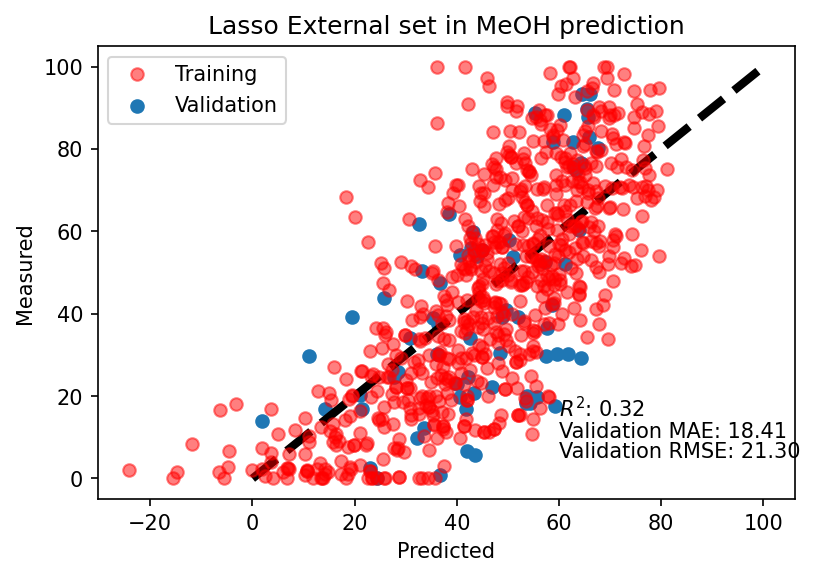

In [12]:
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
ax.scatter(Y_Pred,ext_y,label="Validation")
ax.plot( [0,100],[0,100], 'k--', lw=4)
ax.plot(lasso_search.best_estimator_.predict(X_train), Y_train, "or", alpha=0.5, label="Training")
ax.text(60,15,r'$R^2$: {:0.2f}'.format(r2_score(ext_y,Y_Pred)))
ax.text(60,10,'Validation MAE: {:0.2f}'.format(mean_absolute_error(Y_Pred,ext_y)))
ax.text(60,5,'Validation RMSE: {:0.2f}'.format(np.sqrt(mean_squared_error(Y_Pred,ext_y))))
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
ax.set_title('Lasso External set in MeOH prediction')
plt.legend()
plt.show()

<AxesSubplot:ylabel='feature'>

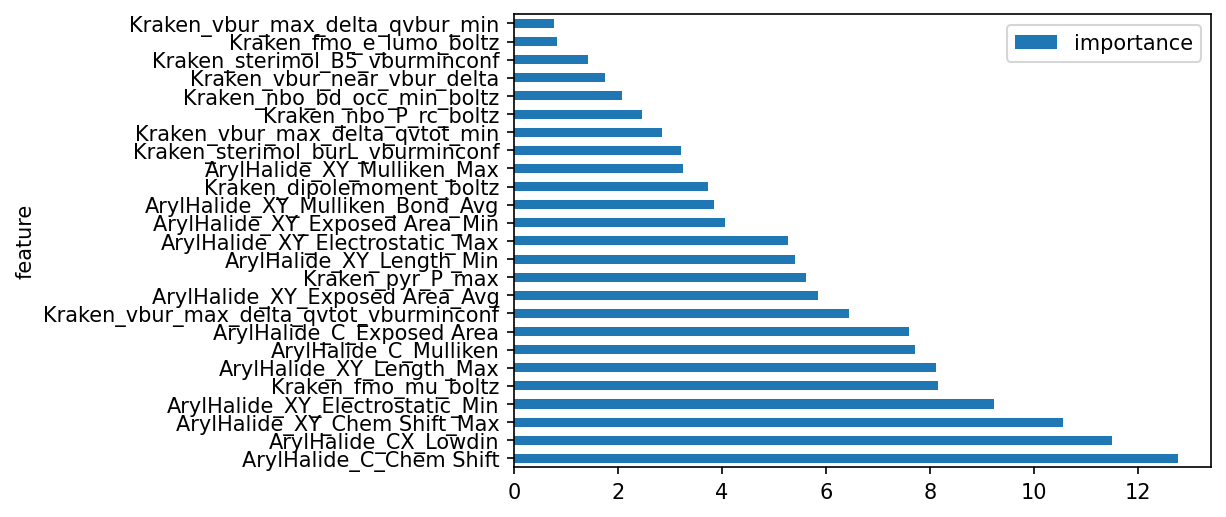

In [13]:
#Top features from Lasso regression, pls note they are quite different from other tree-based ensemble models
coefs=lasso_search.best_estimator_.named_steps['model'].coef_
importance=np.abs(coefs)
features=X_train.columns

df=pd.DataFrame(zip(features,importance))
df2 = df.sort_values(by=[1], ascending=False).head(25)
df2.columns = ['feature', 'importance']
df2.set_index('feature',inplace=True)
df2.plot(kind='barh')

In [14]:
%load_ext watermark

In [15]:
%watermark --iversions

sklearn   : 0.24.0
numpy     : 1.19.2
pandas    : 1.2.0
matplotlib: 3.3.3

